# Deform a sphere into a cube

---


This notebook solves the problem of deforming a sphere into a cube using different methods.


Import the required modules.


In [1]:
import numpy as np
import pyvista as pv
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import numerical_geometry as ng

---

## 1 - Create source and target meshes


We can create a sphere (source) mesh and a cube (target) mesh using the `utils.sphere()` and `utils.cube()` functions respectively. Generating meshes of spheres and cubes is discussed in the `sphere.ipynb` and `cube.ipynb` notebooks respectively. We will also calculate vertex normals for both meshes using the `compute_normals()` function.


In [13]:
sphere_mesh = ng.sphere(
    num_polar_angles=100, num_azimuthal_angles=200
).compute_normals()
cube_mesh = ng.cube(num_points_per_side=50).compute_normals()

Plot the sphere (source) mesh and the cube (target) mesh.


In [14]:
pl = pv.Plotter(shape=(1, 2))

pl.subplot(0, 0)
pl.add_mesh(sphere_mesh, show_edges=True)
pl.add_text("Sphere (source)", font_size=12)

pl.subplot(0, 1)
pl.add_mesh(cube_mesh, show_edges=True)
pl.add_text("Cube (target)", font_size=12)

pl.show()

Widget(value='<iframe src="http://localhost:61132/index.html?ui=P_0x178263250_4&reconnect=auto" class="pyvista…

---

## 2 - Deform a sphere into a cube using ray tracing


The first step to solve this problem is to find where the vertex normals of the sphere intersect the faces of the cube. This is a ray tracing problem, and can be solved using PyVista's built in ray tracing functionality. The ray tracing logic is implemented in the `ng.get_intersection_points()` function, which uses PyVista's `ray_trace()` method to find where the sphere's vertex normals intersect the faces of the cube.


In [5]:
intersection_points, intersection_rays, intersection_cells = (
    ng.geometry.RayTracing.get_intersection_points(
        sphere_mesh,
        cube_mesh,
    )
)

deformation = intersection_points - sphere_mesh.points

To deform the sphere, we simply need to multiply the deformation field, $\vec{d}$, by a scalar, $t \in [0, 1]$, and evolve the position of each vertex according to this new deformation field. This is handled by the `utils.animate_deformation()` function.


In [6]:
ng.plot_deformation(
    source_mesh=sphere_mesh,
    deformation=deformation,
)

Widget(value='<iframe src="http://localhost:61132/index.html?ui=P_0x178262e90_1&reconnect=auto" class="pyvista…

---

## 3 - Deform a sphere into a cube using a neural network


We will now try to solve the problem using a neural network. We will aim to learn a function $f: \mathbb{R}^3 \rightarrow \mathbb{R}^3$ that maps the points of the source mesh to the deformation field. One benefit of this approach is that we can learn the function on a low dimensional representation (i.e. sparse source and target meshes), and then apply the function to a dense source mesh.


Set the device to MPS if available (you will need to modify this block of code if you aren't using an Apple silicon device).


In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

Using mps device.


### 3.1 - Loss function


In order to optimize the parameters, we need a loss function. Our loss function will include 3 terms: a Chamfer distance term, a deformation magnitude regularization term, and a Laplacian regularization term.


In [15]:
lambda_deformation = 1e-3
lambda_laplacian = 1e-3


def loss_function(source, target, deformation):
    """
    Loss function
    =============

    Computes the loss.
    """

    chamfer_distance = ng.chamfer_distance(source + deformation, target)
    deformation_loss = ng.deformation_loss(deformation)
    laplacian_loss = ng.laplacian_loss(source, deformation)

    loss = (
        chamfer_distance
        + (lambda_deformation * deformation_loss)
        + (lambda_laplacian * laplacian_loss)
    )
    return loss

### 3.2 - Create and train the model


We can initialize a multilayer perceptron (MLP) using `ng.NeuralNetwork()`. We can train the model using the `train_model()` function.


[10/200]: loss = 0.053161
[20/200]: loss = 0.032777
[30/200]: loss = 0.026131
[40/200]: loss = 0.025336
[50/200]: loss = 0.024499
[60/200]: loss = 0.024202
[70/200]: loss = 0.024412
[80/200]: loss = 0.024269
[90/200]: loss = 0.023794
[100/200]: loss = 0.024110
[110/200]: loss = 0.023667
[120/200]: loss = 0.023625
[130/200]: loss = 0.023525
[140/200]: loss = 0.023460
[150/200]: loss = 0.023632
[160/200]: loss = 0.023358
[170/200]: loss = 0.023401
[180/200]: loss = 0.023163
[190/200]: loss = 0.022957
[200/200]: loss = 0.023192


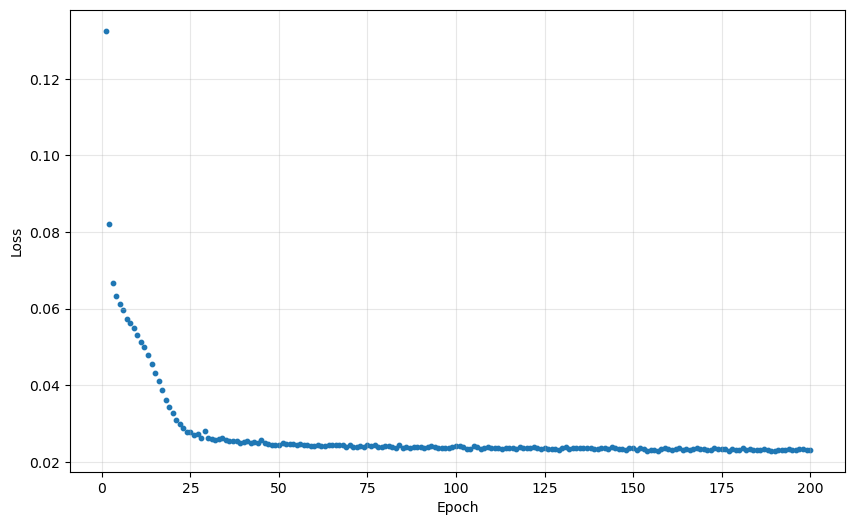

In [16]:
model = ng.NeuralNetwork(parameters=128, layers=4).to(device)

model.train_model(
    source_mesh=sphere_mesh,
    target_mesh=cube_mesh,
    device=device,
    loss_function=loss_function,
    optimizer_type="SGD",
    epochs=200,
    batch_size=512,
    target_batch_size=1000,
    learning_rate=1e-1,
    print_every=10,
)

### 3.3 - Testing


Now that we have trained the model, we can use it to calculate a deformation field, and then apply the deformation field.


In [18]:
sphere_mesh = pv.Sphere(radius=1, theta_resolution=200, phi_resolution=200)
deformation = model.get_deformation_field(sphere_mesh, device)

ng.plot_deformation(source_mesh=sphere_mesh, deformation=deformation, show_edges=False)

Widget(value='<iframe src="http://localhost:61132/index.html?ui=P_0x335964e10_6&reconnect=auto" class="pyvista…